# Construction de réseaux

Dans ce notebook, nous proposons de nous familiariser avec la construction
de réseau avec la bibliothèque python networkx.
Comme d'habitude, nous commençons par importer les bibliothèques nécessaires.

In [30]:
import pandas as pd
import networkx as nx

## Création de graphes

Pour créer un réseau (graphe), il faut d'abord instancier un objet `nx.Graph`, par exemple, de la façon suivante:

In [31]:
G = nx.Graph()

Pour le moment, le graph est vide. Pour le construire, il nous faut ajouter des noeuds (*nodes*) et des liens (*edges*).
Par exemple, pour créer un graphe avec deux noeuds (Alice & Bob) et une relation entre Alice et Bob:

In [32]:
G.add_node("alice")
G.add_node("bob")
G.add_edge("alice", "bob")
G.nodes

NodeView(('alice', 'bob'))

On peut visualiser le graphe à l'aide de la fonction `nx.draw()`:

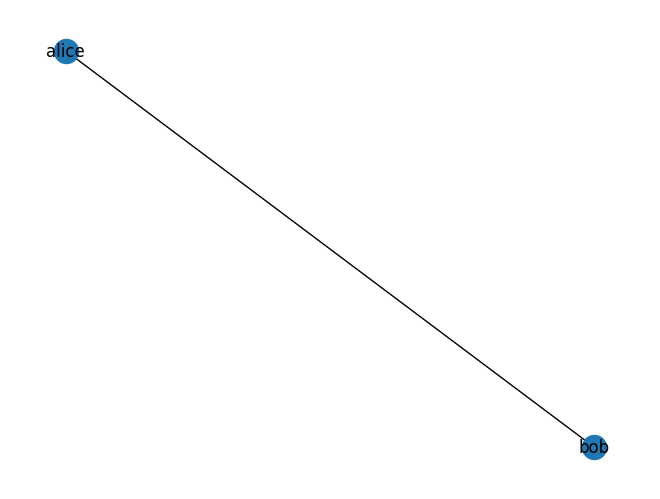

In [33]:
nx.draw(G, with_labels=True)

networkx distingue les graphes:
 - *non dirigés* (*non-directed*, pour lesquels les relations entre noeuds sont symétriques); par exemple, qui a échangé une poignée de main avec qui?
 - dirigés (*directed*, pour lesquels les relations sont asymétriques en général); par exemple, qui apprécie qui

Un graphe dirigé peut-être instancié de la façon suivante:


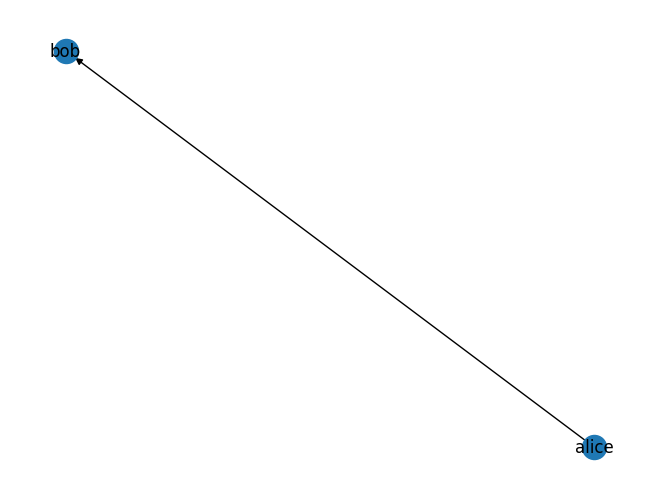

In [34]:
dG = nx.DiGraph() # DiGraph() au lieu de Graph()!
dG.add_node("alice")
dG.add_node("bob")
dG.add_edge("alice", "bob") # alice -> bob (l'ordre a une importance!)
nx.draw(dG, with_labels=True)

Ci-dessus, on peut noter que le lien entre Alice est Bob est orienté, selon le sens de la flèche.
Pour apprécier la différence entre graphs dirigés et non-dirigés, on peut aussi comparer les matrices d'adjacence de G et dG. Celle de dG est non symétrique:

In [35]:
print(nx.adjacency_matrix(G).toarray())
print(nx.adjacency_matrix(dG).toarray())

[[0 1]
 [1 0]]
[[0 1]
 [0 0]]


Les graphes dirigés peuvent cependent tout à fait posséder des liens dans deux sens superposés:

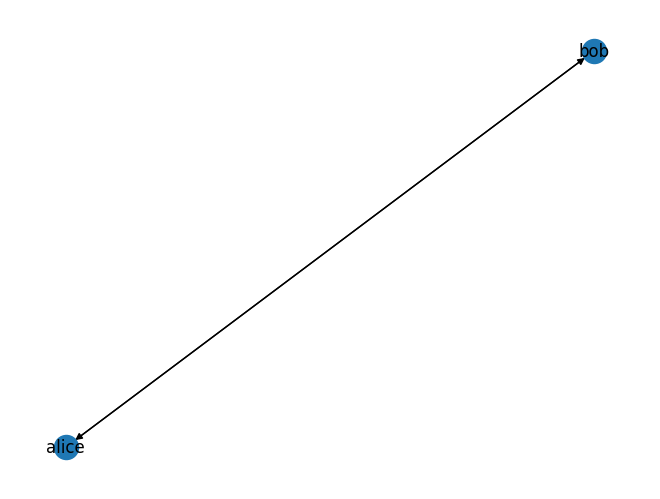

In [36]:
dG.add_edge("bob", "alice") # bob -> alice
nx.draw(dG, with_labels=True)

## Attributs

networkx permet de doter les noeuds et les liens d'*attributs*. Par exemple, pour définir un attribute genre:

In [37]:
# dictionnaire décrivant la relation noeud: attribut
values = {
    "alice": "female",
    "bob": "male"
}

# assignant des attributs
nx.set_node_attributes(
    G, # le graph pour lequel l'attribut sera défini
    values, # relation entre noeud et valeur de l'attribut
    name="gender" # nom de l'attribut
)

nx.get_node_attributes(G, "gender")

{'alice': 'female', 'bob': 'male'}

De la même façon, les liens peuvent posséder des attributs; par exemple:

In [38]:
G["alice"]["bob"]["handshakes"] = 2
nx.get_edge_attributes(G, "handshakes")

{('alice', 'bob'): 2}

## Un vrai exemple

In [39]:
authors = pd.read_parquet("science/climate/authors.parquet")
authors.fillna("unknown", inplace=True)
authors = authors.to_dict(orient="index")


In [12]:
authors['5077016639']

{'name': 'A. Clain',
 'orcid': 'https://orcid.org/0000-0002-5310-823X',
 'gender': 'unknown'}

In [40]:
# populate the graph with the authors

G = nx.Graph()

for author_id in authors:
    G.add_node(author_id, gender=authors[author_id]["gender"])

nx.get_node_attributes(G, "gender")

{'5077016639': 'unknown',
 '5094330189': 'm',
 '5094330190': 'unknown',
 '5094330191': 'unknown',
 '5087828342': 'unknown',
 '5108781923': 'm',
 '5059416047': 'm',
 '5013888718': 'm',
 '5064023386': 'unknown',
 '5079457321': 'f',
 '5008683842': 'f',
 '5009216388': 'm',
 '5072884529': 'm',
 '5002595563': 'm',
 '5028294759': 'f',
 '5100347181': 'f',
 '5060135910': 'unknown',
 '5054907946': 'unknown',
 '5085183483': 'unknown',
 '5058232902': 'f',
 '5061565490': 'unknown',
 '5059956268': 'f',
 '5012294071': 'f',
 '5043118546': 'f',
 '5031304523': 'f',
 '5034019633': 'f',
 '5056074749': 'm',
 '5021937105': 'm',
 '5027715439': 'm',
 '5002685504': 'm',
 '5076506413': 'm',
 '5056321396': 'unknown',
 '5112030361': 'f',
 '5003358177': 'm',
 '5052387017': 'f',
 '5043374632': 'f',
 '5079600305': 'f',
 '5001724328': 'f',
 '5023494490': 'unknown',
 '5022865387': 'm',
 '5112326869': 'unisex',
 '5111483414': 'f',
 '5058529749': 'm',
 '5109849729': 'm',
 '5085599162': 'f',
 '5048936466': 'm',
 '5059191

In [41]:
# load data necessary to constructing co-authorship relationships

articles_authors = pd.read_parquet("science/climate/articles_authors.parquet")
articles_authors

,author_id,article_id,position
index,,,
0,5077016639,4393546166,first
1,5094330189,4393546166,middle
2,5094330190,4393546166,middle
3,5094330191,4393546166,last
4,5077016639,4393714386,first
...,...,...,...
912596,5059381830,4389633312,first
912597,5104215399,4389862110,first
912598,5112757995,4389881210,first


In [43]:
# Ajout d'un lien entre co-auteurs d'une même publication:

for article_id, article_authors in articles_authors.groupby("article_id"):
    article_authors = article_authors["author_id"].tolist()

    # on ignore les publications avec > 4 auteurs
    if len(article_authors) > 8 or len(article_authors) < 2:
        continue

    weight = 1/(len(article_authors)-1)
    # pour chaque paire d'auteur:
    for i, author1 in enumerate(article_authors):
        for j, author2 in enumerate(article_authors):
            if (i >= j):
                continue

            if not G.has_edge(author1, author2):
                G.add_edge(author1, author2, publications=1, weight=weight)
            else:
                G[author1][author2]["publications"] += 1
                G[author1][author2]["weight"] += 1

print("nodes:", len(G.nodes)) # print amount of nodes
print("edges:", len(G.edges)) # print amount of edges

nodes: 383274
edges: 798012


On peut maintenant sauvegarder notre graphe dans un fichier. Mais avant, filtrons les noeuds (auteurs) dépourvus de co-auteurs:

In [44]:
degree = dict(nx.degree(G))
nodes = [node for node in G.nodes if degree[node]>0]
G = G.subgraph(nodes)
print("nodes:", len(G.nodes)) # print amount of nodes
print("edges:", len(G.edges)) # print amount of edges

nodes: 282680
edges: 798012


In [46]:
nx.set_node_attributes(G, authors)
G = nx.Graph(G)
G.remove_edges_from([(a,b) for a, b, attrs in G.edges(data=True) if attrs["weight"] < 1])
nx.write_gexf(G, "output/coauthors.gexf")

## Visualisation

Comment visualiser le réseau ainsi créé?

In [50]:
nodes = [node for node in G.nodes if degree[node]>=30]
G_dense = G.subgraph(nodes)
print("nodes:", len(G_dense.nodes)) # print amount of nodes
print("edges:", len(G_dense.edges)) # print amount of edges

nodes: 4019
edges: 15650


In [51]:
pos = nx.spring_layout(G_dense, iterations=20)

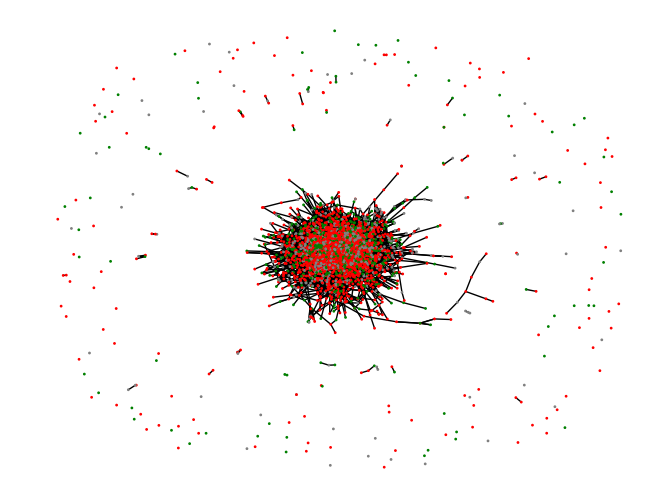

In [52]:
gender_color = {
    "m": "red",
    "f": "green",
}

nodes = G_dense.nodes
nx.draw(
    G_dense,
    pos=pos,
    nodelist=nodes,
    node_color=[gender_color.get(G_dense.nodes[node]["gender"], "gray") for node in nodes],
    node_size=1
)

In [58]:
n_articles = articles_authors.groupby("article_id").agg(n=("author_id", pd.Series.nunique))
articles_authors = articles_authors.merge(n_articles, how="inner", left_on="article_id", right_index=True)
articles_authors = articles_authors[articles_authors["n"]<=8]

In [59]:
authors_lookup = articles_authors.groupby("article_id")["author_id"].apply(lambda x: set(x)).to_dict()

In [60]:
references = pd.read_parquet("science/climate/references.parquet")

In [61]:
G_citations = nx.DiGraph()

for cites_id, _cited in references.groupby("cites"):
    if cites_id not in authors_lookup:
        continue
        
    cites = authors_lookup[cites_id]
    n_cites = len(cites)
    _cited = _cited["cited"].tolist()

    for cited_id in _cited:
        if cited_id not in authors_lookup:
            continue

        cited = authors_lookup[cited_id]
        n_cited = len(cited)

        for a in cites:
            for b in cited:
                if a==b:
                    continue

                if a not in G_citations.nodes:
                    G_citations.add_node(a)

                if b not in G_citations.nodes:
                    G_citations.add_node(b)

                if G_citations.has_edge(a, b):
                    G_citations[a][b]["weight"] += 1 / (n_cites*n_cited)
                else:
                    G_citations.add_edge(
                        a,
                        b,
                        weight=1 / (n_cites*n_cited),
                    )

In [62]:
nx.set_node_attributes(
    G_citations, # le graph pour lequel l'attribut sera défini
    authors
)

In [63]:
print(len(G.edges))

329743


In [64]:
G = nx.Graph(G)
G.remove_edges_from([(a,b) for a, b, attrs in G.edges(data=True) if attrs["weight"] < 1])
nx.write_gexf(G_citations, "output/citations.gexf")